In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

/home/paperspace/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
path = "../data/ml-20m/"
ratings = pd.read_csv(path + "ratings.csv")

In [3]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [5]:
ratings.shape

(20000263, 4)

In [6]:
print(f"full dataset:\nnumber users {int(ratings.userId.nunique())}, number movies {int(ratings.movieId.nunique())}")

full dataset:
number users 138493, number movies 26744


In [7]:
# ratings = ratings.sample(n=500000)

In [7]:
# 20m data points, validation set 5% will result in 1m validation datapoints
val_idxs = get_cv_idxs(n=len(ratings), val_pct=0.05)

In [8]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [9]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())
n_factors = 100
print(f"number users: {n_users}, number movies {n_movies}")

number users: 138493, number movies 26744


In [10]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()

In [11]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [12]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [13]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

In [14]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        
        # layer 1 fully connected 150 units
        self.lin1 = nn.Linear(n_factors*2, 150)
        
        # layer 2 fully connected 50 units
        self.lin2 = nn.Linear(150, 50)
        
        # layer 3 fully connected 1 unit (output)
        self.lin3 = nn.Linear(50, 1)
        
        # dropouts
        self.drop1 = nn.Dropout(0.5)
        self.drop2 = nn.Dropout(0.4)
        self.drop3 = nn.Dropout(0.25)
        
    def forward(self, cats, conts):
        
        # extracting user and movie indices from ColumnarModelData object
        users,movies = cats[:,0],cats[:,1]
        
        # extract input vector from embedding matrices
        x = torch.cat([self.u(users),self.m(movies)], dim=1)
        
        # perform dropout on input vector embeddings
        x = self.drop1(x)
        
        # first hidden layer
        x = self.drop2(F.relu(self.lin1(x)))
        
        # second hidden layer
        x = self.drop3(F.relu(self.lin2(x)))
        
        # output
        x = F.sigmoid(self.lin3(x)) * (max_rating-min_rating+1) + min_rating-0.5
        
        return x  

In [16]:
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [20]:
set_lrs(opt, 1e-3)

In [21]:
fit(model, data, 1, opt, F.mse_loss)

epoch      trn_loss   val_loss                                       
    0      0.719011   0.696099  



[array([0.6961])]

In [28]:
fit(model, data, 1, opt, F.mse_loss)

 45%|████▌     | 133706/296879 [33:29<40:52, 66.55it/s, loss=0.685] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 48%|████▊     | 141226/296879 [35:20<38:56, 66.60it/s, loss=0.688]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50%|█████     | 148825/296879 [37:17<37:05, 66.53it/s, loss=0.728]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 53%|█████▎    | 156451/296879 [39:11<35:10, 66.53it/s, loss=0.685]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55%|█████▌    | 163853/296879 [41:04<33:20, 66.49it/s, loss=0.723]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 58%|█████▊    | 171316/296879 [42:55<31:27, 66.53it/s, loss=0.71] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch      trn_loss   val_loss                                       
    0      0.700202   0.696099  



[array([0.6961])]

In [29]:
set_lrs(opt, 2*1e-3)

In [30]:
fit(model, data, 1, opt, F.mse_loss)

epoch      trn_loss   val_loss                                       
    0      0.724877   0.712612  



[array([0.71261])]

In [31]:
set_lrs(opt, 0.7*1e-3)

In [32]:
fit(model, data, 1, opt, F.mse_loss)

epoch      trn_loss   val_loss                                       
    0      0.747834   0.701881  



[array([0.70188])]

In [34]:
fit(model, data, 1, opt, F.mse_loss)

epoch      trn_loss   val_loss                                       
    0      0.688554   0.678666  



[array([0.67867])]

In [20]:
bm = BasicModel(model)

In [21]:
learner = StructuredLearner(data, bm)

In [22]:
# needs a StructuredModel(MixedInputModel)
learner.lr_find()

 80%|███████▉  | 236329/296879 [39:00<09:59, 100.97it/s, loss=2.62] 

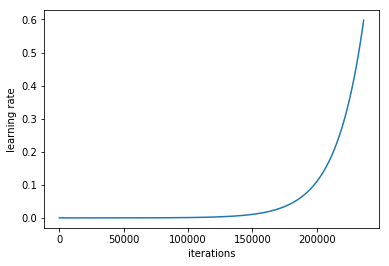

In [24]:
learner.sched.plot_lr()

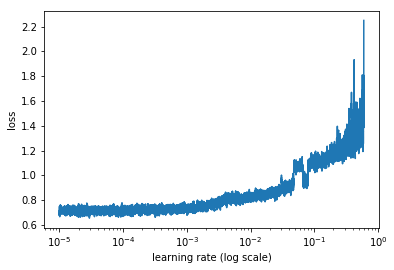

In [26]:
learner.sched.plot()

In [29]:
model.drop1.p = 0.3
model.drop2.p = 0.1
model.drop3.p = 0.05

In [30]:
set_lrs(opt, 2*1e-4)

In [33]:
fit(model, data, 1, opt, F.mse_loss)

epoch      trn_loss   val_loss                                       
    0      0.66289    0.675786  


[array([0.67579])]

## persist embedding matrices

In [34]:
user_embeddings = pd.DataFrame(model.u.weight.data.cpu().numpy())
user_embeddings.to_pickle("../data/collaborative_embeddings/user_embeddings_1.pkl")

In [35]:
movie_embeddings = pd.DataFrame(model.m.weight.data.cpu().numpy())
movie_embeddings.to_pickle("../data/collaborative_embeddings/movie_embeddings_1.pkl")

## persist model parameters

In [36]:
with open('../models/embedding_net_state_dict.pytorch', 'wb') as fh:
    pickle.dump(model.state_dict(), fh)

## depersist model parameters and load them into model

In [17]:
with open('../models/embedding_net_state_dict.pytorch', 'rb') as fh:
    state_dict = pickle.load(fh)

In [19]:
model.load_state_dict(state_dict)